In [ ]:
#mathews correlation takes into account the class imbalance
#try to get more variables and changed the LSTM architecture (maybe GRUs, cnns, etc.)
#can conv1d play a part in the 800K selection

In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
sample_size = 800000

In [90]:
# It is the official metric used in this competition
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    
    '''
    #y_pred = tf.convert_to_tensor(y_pred, np.float64)
    #y_true = tf.convert_to_tensor(y_true, np.float64)
    
    
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [5]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [6]:
# just load train data
df_train = pd.read_csv('metadata_train.csv')
# set index, it makes the data access much faster
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head(10)

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1
               2              5       1
2              0              6       0
               1              7       0
               2              8       0
3              0              9       0

In [7]:
# in other notebook I have extracted the min and max values from the train data, the measurements
max_num = 127
min_num = -128

In [8]:
# This function standardize the data from (-128 to 127) to (-1 to 1)
# Theoretically it helps in the NN Model training, but I didn't tested without it
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [12]:
# This is one of the most important peace of code of this Kernel
# Any power line contain 3 phases of 800000 measurements, or 2.4 millions data 
# It would be praticaly impossible to build a NN with an input of that size
# The ideia here is to reduce it each phase to a matrix of <n_dim> bins by n features
# Each bean is a set of 5000 measurements (800000 / 160), so the features are extracted from this 5000 chunk data.
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    # bucket or chunk size, 5000 in this case (800000 / 160)
    bucket_size = int(sample_size / n_dim)
    # new_ts will be the container of the new data
    new_ts = []
    # this for iteract any chunk/bucket until reach the whole sample_size (800000)
    for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size]
        # calculate each feature
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std
        std_bot = mean - std
        # I think that the percentiles are very important, it is like a distribuiton analysis from eath chunk
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
        # now, we just add all the features to new_ts and convert it to np.array
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [13]:
# this function take a piece of data and convert using transform_ts(), but it does to each of the 3 phases
# if we would try to do in one time, could exceed the RAM Memmory
def prep_data(start, end):
    # load a piece of data from file
    praq_train = pq.read_pandas('train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
    # using tdqm to evaluate processing time
    # takes each index from df_train and iteract it from start to end
    # it is divided by 3 because for each id_measurement there are 3 id_signal, and the start/end parameters are id_signal
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        count = 0
        X_signal = []
        #for each id_measurement
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            # but just append the target one time, to not triplicate it
            #this should be more accurate than just appeneding phase = 0 target value
            if target == 1:
                count = 1
            # extract and transform data into sets of features
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        # concatenate all the 3 phases in one matrix
        y.append(count)
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [14]:
# this code is very simple, divide the total size of the df_train into two sets and process it
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prep_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)

100%|██████████████████████████████████████████████████████████████████████████████| 1452/1452 [11:39<00:00,  1.80it/s]


In [15]:
# The X shape here is very important. It is also important undertand a little how a LSTM works
# X.shape[0] is the number of id_measuremts contained in train data
#each id_measurement/phase combo has 800K points associated with it and a resulting 0 or 1 classification

# X.shape[1] is the number of chunks resultant of the transformation, each of this date enters in the LSTM serialized
# This way the LSTM can understand the position of a data relative with other and activate a signal that needs
# a serie of inputs in a specifc order.
# X.shape[2] is the number of features multiplied by the number of phases (3)
print(X.shape, y.shape)
# save data into file, a numpy specific format
np.save("X_true.npy",X)
np.save("y_true.npy",y)

(2904, 160, 57) (2904,)


In [10]:
#load if necessary
X = np.load("X_true.npy")
y = np.load("Y_true.npy")

In [67]:
# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
    x = Attention(input_shape[1])(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
    x = Dense(64, activation="relu")(x)
    # A binnary classification as this must finish with shape (1,)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [91]:
# Here is where the training happens

# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt]) #i have added this for now
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - ETA: 31s - loss: 0.6833 - matthews_correlation: 0.068 - ETA: 16s - loss: 0.6702 - matthews_correlation: 0.034 - ETA: 11s - loss: 0.6547 - matthews_correlation: 0.022 - ETA: 8s - loss: 0.6306 - matthews_correlation: 0.017 - ETA: 7s - loss: 0.6093 - matthews_correlation: 0.01 - ETA: 6s - loss: 0.5779 - matthews_correlation: 0.01 - ETA: 5s - loss: 0.5467 - matthews_correlation: 0.00 - ETA: 4s - loss: 0.5291 - matthews_correlation: 0.00 - ETA: 3s - loss: 0.4964 - matthews_correlation: 0.00 - ETA: 3s - loss: 0.4757 - matthews_correlation: 0.00 - ETA: 2s - loss: 0.4556 - matthews_correlation: 0.00 - ETA: 2s - loss: 0.4262 - matthews_correlation: 0.00 - ETA: 1s - loss: 0.4111 - matthews_correlation: 0.00 - ETA: 1s - loss: 0.3985 - matthews_correlation: 0.00 - ETA: 1s - loss: 0.3901 - matthews_correlation: 0.00 - ETA: 0s - loss: 0.3844 - matthews_correlation: 0.00 - ETA: 0s -

2323/2323 [==============================] - ETA: 3s - loss: 0.1736 - matthews_correlation: 0.38 - ETA: 3s - loss: 0.1597 - matthews_correlation: 0.30 - ETA: 3s - loss: 0.1820 - matthews_correlation: 0.31 - ETA: 3s - loss: 0.1636 - matthews_correlation: 0.28 - ETA: 2s - loss: 0.1640 - matthews_correlation: 0.28 - ETA: 2s - loss: 0.1523 - matthews_correlation: 0.34 - ETA: 2s - loss: 0.1602 - matthews_correlation: 0.36 - ETA: 2s - loss: 0.1616 - matthews_correlation: 0.37 - ETA: 2s - loss: 0.1817 - matthews_correlation: 0.37 - ETA: 1s - loss: 0.1762 - matthews_correlation: 0.40 - ETA: 1s - loss: 0.1794 - matthews_correlation: 0.40 - ETA: 1s - loss: 0.1714 - matthews_correlation: 0.43 - ETA: 1s - loss: 0.1679 - matthews_correlation: 0.44 - ETA: 0s - loss: 0.1662 - matthews_correlation: 0.45 - ETA: 0s - loss: 0.1622 - matthews_correlation: 0.47 - ETA: 0s - loss: 0.1643 - matthews_correlation: 0.47 - ETA: 0s - loss: 0.1616 - matthews_correlation: 0.48 - ETA: 0s - loss: 0.1575 - matthews_cor

2323/2323 [==============================] - ETA: 3s - loss: 0.0913 - matthews_correlation: 0.84 - ETA: 3s - loss: 0.0779 - matthews_correlation: 0.87 - ETA: 3s - loss: 0.1008 - matthews_correlation: 0.68 - ETA: 3s - loss: 0.1124 - matthews_correlation: 0.70 - ETA: 2s - loss: 0.1060 - matthews_correlation: 0.70 - ETA: 2s - loss: 0.1030 - matthews_correlation: 0.73 - ETA: 2s - loss: 0.0997 - matthews_correlation: 0.73 - ETA: 2s - loss: 0.0960 - matthews_correlation: 0.73 - ETA: 2s - loss: 0.0958 - matthews_correlation: 0.73 - ETA: 1s - loss: 0.1011 - matthews_correlation: 0.71 - ETA: 1s - loss: 0.1039 - matthews_correlation: 0.71 - ETA: 1s - loss: 0.1017 - matthews_correlation: 0.72 - ETA: 1s - loss: 0.0993 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0975 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0983 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0974 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0964 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.0960 - matthews_cor

2323/2323 [==============================] - ETA: 3s - loss: 0.1216 - matthews_correlation: 0.76 - ETA: 3s - loss: 0.1022 - matthews_correlation: 0.63 - ETA: 3s - loss: 0.0915 - matthews_correlation: 0.69 - ETA: 3s - loss: 0.0827 - matthews_correlation: 0.76 - ETA: 2s - loss: 0.0764 - matthews_correlation: 0.77 - ETA: 2s - loss: 0.0767 - matthews_correlation: 0.80 - ETA: 2s - loss: 0.0869 - matthews_correlation: 0.74 - ETA: 2s - loss: 0.0780 - matthews_correlation: 0.77 - ETA: 2s - loss: 0.0804 - matthews_correlation: 0.75 - ETA: 1s - loss: 0.0984 - matthews_correlation: 0.73 - ETA: 1s - loss: 0.0930 - matthews_correlation: 0.73 - ETA: 1s - loss: 0.0953 - matthews_correlation: 0.73 - ETA: 1s - loss: 0.1010 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0977 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0958 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0945 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0922 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0907 - matthews_cor

2323/2323 [==============================] - ETA: 3s - loss: 0.0852 - matthews_correlation: 0.86 - ETA: 3s - loss: 0.1205 - matthews_correlation: 0.66 - ETA: 3s - loss: 0.1201 - matthews_correlation: 0.64 - ETA: 3s - loss: 0.1153 - matthews_correlation: 0.64 - ETA: 2s - loss: 0.1007 - matthews_correlation: 0.70 - ETA: 2s - loss: 0.1001 - matthews_correlation: 0.71 - ETA: 2s - loss: 0.0938 - matthews_correlation: 0.71 - ETA: 2s - loss: 0.0949 - matthews_correlation: 0.72 - ETA: 2s - loss: 0.0937 - matthews_correlation: 0.71 - ETA: 1s - loss: 0.0912 - matthews_correlation: 0.71 - ETA: 1s - loss: 0.0888 - matthews_correlation: 0.71 - ETA: 1s - loss: 0.0852 - matthews_correlation: 0.72 - ETA: 1s - loss: 0.0879 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0854 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0892 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0918 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0909 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0883 - matthews_cor

KeyboardInterrupt: 

In [68]:
#stratify split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify = y)

#add in checkpoints and early stopping metrics
earlyStopping = EarlyStopping(monitor='val_matthews_correlation', patience=15, verbose=1, mode='min')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_matthews_correlation', mode='min')
#slow down learning rate if you start plateauing
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_matthews_correlation', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')


#build model and initialize shape
model = model_lstm(X.shape)
# This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
# validation matthews_correlation greater than the last one.
model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, callbacks=[mcp_save], validation_data=(X_test, y_test))

Train on 2613 samples, validate on 291 samples
Epoch 1/50
2613/2613 [==============================] - ETA: 1:14 - loss: 0.6992 - matthews_correlation: -0.024 - ETA: 37s - loss: 0.6779 - matthews_correlation: -0.012 - ETA: 24s - loss: 0.6529 - matthews_correlation: -0.00 - ETA: 18s - loss: 0.6295 - matthews_correlation: -0.00 - ETA: 14s - loss: 0.5986 - matthews_correlation: -0.00 - ETA: 11s - loss: 0.5615 - matthews_correlation: -0.00 - ETA: 9s - loss: 0.5295 - matthews_correlation: -0.0035 - ETA: 8s - loss: 0.4992 - matthews_correlation: -0.003 - ETA: 7s - loss: 0.4849 - matthews_correlation: -0.002 - ETA: 6s - loss: 0.4753 - matthews_correlation: -0.002 - ETA: 5s - loss: 0.4618 - matthews_correlation: -0.002 - ETA: 4s - loss: 0.4410 - matthews_correlation: -0.002 - ETA: 3s - loss: 0.4372 - matthews_correlation: -0.001 - ETA: 3s - loss: 0.4229 - matthews_correlation: -0.001 - ETA: 2s - loss: 0.4064 - matthews_correlation: -0.001 - ETA: 2s - loss: 0.3942 - matthews_correlation: -0.001

2613/2613 [==============================] - ETA: 4s - loss: 0.0870 - matthews_correlation: 0.78 - ETA: 4s - loss: 0.0963 - matthews_correlation: 0.76 - ETA: 4s - loss: 0.0990 - matthews_correlation: 0.70 - ETA: 3s - loss: 0.1132 - matthews_correlation: 0.66 - ETA: 3s - loss: 0.1189 - matthews_correlation: 0.64 - ETA: 3s - loss: 0.1190 - matthews_correlation: 0.66 - ETA: 3s - loss: 0.1156 - matthews_correlation: 0.67 - ETA: 2s - loss: 0.1177 - matthews_correlation: 0.66 - ETA: 2s - loss: 0.1191 - matthews_correlation: 0.65 - ETA: 2s - loss: 0.1151 - matthews_correlation: 0.67 - ETA: 2s - loss: 0.1170 - matthews_correlation: 0.65 - ETA: 1s - loss: 0.1145 - matthews_correlation: 0.66 - ETA: 1s - loss: 0.1110 - matthews_correlation: 0.67 - ETA: 1s - loss: 0.1080 - matthews_correlation: 0.68 - ETA: 1s - loss: 0.1094 - matthews_correlation: 0.68 - ETA: 1s - loss: 0.1092 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1054 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.1122 - matthews_cor

2613/2613 [==============================] - ETA: 4s - loss: 0.0487 - matthews_correlation: 0.89 - ETA: 4s - loss: 0.0572 - matthews_correlation: 0.79 - ETA: 3s - loss: 0.0633 - matthews_correlation: 0.73 - ETA: 3s - loss: 0.0802 - matthews_correlation: 0.64 - ETA: 3s - loss: 0.1023 - matthews_correlation: 0.60 - ETA: 3s - loss: 0.1000 - matthews_correlation: 0.64 - ETA: 3s - loss: 0.0913 - matthews_correlation: 0.68 - ETA: 2s - loss: 0.0960 - matthews_correlation: 0.66 - ETA: 2s - loss: 0.0925 - matthews_correlation: 0.66 - ETA: 2s - loss: 0.0959 - matthews_correlation: 0.65 - ETA: 2s - loss: 0.0987 - matthews_correlation: 0.66 - ETA: 1s - loss: 0.0983 - matthews_correlation: 0.65 - ETA: 1s - loss: 0.1018 - matthews_correlation: 0.65 - ETA: 1s - loss: 0.1053 - matthews_correlation: 0.65 - ETA: 1s - loss: 0.1054 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1048 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1052 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1079 - matthews_cor

2613/2613 [==============================] - ETA: 4s - loss: 0.1237 - matthews_correlation: 0.36 - ETA: 4s - loss: 0.1020 - matthews_correlation: 0.59 - ETA: 3s - loss: 0.0879 - matthews_correlation: 0.61 - ETA: 3s - loss: 0.0843 - matthews_correlation: 0.62 - ETA: 3s - loss: 0.0881 - matthews_correlation: 0.64 - ETA: 3s - loss: 0.0844 - matthews_correlation: 0.67 - ETA: 3s - loss: 0.0895 - matthews_correlation: 0.65 - ETA: 2s - loss: 0.0867 - matthews_correlation: 0.67 - ETA: 2s - loss: 0.0847 - matthews_correlation: 0.67 - ETA: 2s - loss: 0.0873 - matthews_correlation: 0.69 - ETA: 2s - loss: 0.0883 - matthews_correlation: 0.69 - ETA: 1s - loss: 0.0867 - matthews_correlation: 0.70 - ETA: 1s - loss: 0.0895 - matthews_correlation: 0.68 - ETA: 1s - loss: 0.0902 - matthews_correlation: 0.70 - ETA: 1s - loss: 0.0875 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0881 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0863 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0872 - matthews_cor

2613/2613 [==============================] - ETA: 4s - loss: 0.0892 - matthews_correlation: 0.64 - ETA: 4s - loss: 0.0736 - matthews_correlation: 0.72 - ETA: 3s - loss: 0.0964 - matthews_correlation: 0.66 - ETA: 3s - loss: 0.0892 - matthews_correlation: 0.71 - ETA: 3s - loss: 0.0995 - matthews_correlation: 0.72 - ETA: 3s - loss: 0.0966 - matthews_correlation: 0.74 - ETA: 3s - loss: 0.1013 - matthews_correlation: 0.71 - ETA: 2s - loss: 0.0998 - matthews_correlation: 0.70 - ETA: 2s - loss: 0.0982 - matthews_correlation: 0.72 - ETA: 2s - loss: 0.0929 - matthews_correlation: 0.73 - ETA: 2s - loss: 0.0885 - matthews_correlation: 0.74 - ETA: 1s - loss: 0.0845 - matthews_correlation: 0.75 - ETA: 1s - loss: 0.0862 - matthews_correlation: 0.75 - ETA: 1s - loss: 0.0830 - matthews_correlation: 0.76 - ETA: 1s - loss: 0.0852 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0857 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0875 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0851 - matthews_cor

In [69]:
#check how it did
#model.load_weights('mdl_wts.hdf5')
preds_train = []
y_train = []
preds_train.append(model.predict(X, batch_size=512))
# and the val true y
y_train.append(y)

In [70]:
preds_train = np.concatenate(preds_train)[...,0]
y_train = np.concatenate(y_train)

In [71]:
# The output of this kernel must be binary (0 or 1), but the output of the NN Model is float (0 to 1).
# So, find the best threshold to convert float to binary is crucial to the result
# this piece of code is a function that evaluates all the possible thresholds from 0 to 1 by 0.01
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = K.eval(matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64)))
        print(score)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    return search_result

In [74]:
best_threshold = threshold_search(y_train, preds_train)['threshold']

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.0


  1%|▊                                                                                 | 1/100 [00:01<01:58,  1.20s/it]

0.4451470854047643


  2%|█▋                                                                                | 2/100 [00:02<01:46,  1.09s/it]

0.535619407121313


  3%|██▍                                                                               | 3/100 [00:02<01:39,  1.02s/it]

0.575209599039852


  4%|███▎                                                                              | 4/100 [00:03<01:32,  1.03it/s]

0.5938796154108168


  5%|████                                                                              | 5/100 [00:04<01:28,  1.07it/s]

0.6092885808199293


  6%|████▉                                                                             | 6/100 [00:05<01:30,  1.04it/s]

0.6282121694165967


  7%|█████▋                                                                            | 7/100 [00:06<01:27,  1.06it/s]

0.6422329719218206


  8%|██████▌                                                                           | 8/100 [00:07<01:23,  1.10it/s]

0.6640920534630255


  9%|███████▍                                                                          | 9/100 [00:08<01:21,  1.12it/s]

0.6713832521831489


 10%|████████                                                                         | 10/100 [00:09<01:19,  1.14it/s]

0.6766201690207375


 11%|████████▉                                                                        | 11/100 [00:09<01:17,  1.15it/s]

0.6929617370573355


 12%|█████████▋                                                                       | 12/100 [00:10<01:17,  1.14it/s]

0.7030217359042781


 13%|██████████▌                                                                      | 13/100 [00:11<01:15,  1.15it/s]

0.7105111636793456


 14%|███████████▎                                                                     | 14/100 [00:12<01:14,  1.16it/s]

0.7162712126740838


 15%|████████████▏                                                                    | 15/100 [00:13<01:13,  1.16it/s]

0.7236391680642283


 16%|████████████▉                                                                    | 16/100 [00:14<01:15,  1.11it/s]

0.7234192316503273


 17%|█████████████▊                                                                   | 17/100 [00:15<01:17,  1.07it/s]

0.7326166210198278


 18%|██████████████▌                                                                  | 18/100 [00:16<01:17,  1.06it/s]

0.7341013921518046


 19%|███████████████▍                                                                 | 19/100 [00:17<01:14,  1.09it/s]

0.7372860832801492


 20%|████████████████▏                                                                | 20/100 [00:18<01:13,  1.09it/s]

0.7421734296515494


 21%|█████████████████                                                                | 21/100 [00:18<01:11,  1.10it/s]

0.7454863009558784


 22%|█████████████████▊                                                               | 22/100 [00:19<01:10,  1.11it/s]

0.74067545498123


 23%|██████████████████▋                                                              | 23/100 [00:20<01:09,  1.11it/s]

0.744048696761933


 24%|███████████████████▍                                                             | 24/100 [00:21<01:07,  1.12it/s]

0.7494092150092414


 25%|████████████████████▎                                                            | 25/100 [00:22<01:05,  1.14it/s]

0.7564861011145161


 26%|█████████████████████                                                            | 26/100 [00:23<01:08,  1.09it/s]

0.755032239197466


 27%|█████████████████████▊                                                           | 27/100 [00:24<01:07,  1.08it/s]

0.7568406244335617


 28%|██████████████████████▋                                                          | 28/100 [00:25<01:06,  1.08it/s]

0.7535832982796983


 29%|███████████████████████▍                                                         | 29/100 [00:26<01:05,  1.09it/s]

0.7535832982796983


 30%|████████████████████████▎                                                        | 30/100 [00:27<01:04,  1.09it/s]

0.7535832982796983


 31%|█████████████████████████                                                        | 31/100 [00:28<01:04,  1.07it/s]

0.755404146182488


 32%|█████████████████████████▉                                                       | 32/100 [00:29<01:05,  1.04it/s]

0.7576746686562836


 33%|██████████████████████████▋                                                      | 33/100 [00:30<01:08,  1.02s/it]

0.7614234380389553


 34%|███████████████████████████▌                                                     | 34/100 [00:31<01:05,  1.02it/s]

0.7633157943645587


 35%|████████████████████████████▎                                                    | 35/100 [00:32<01:01,  1.05it/s]

0.769066355970622


 36%|█████████████████████████████▏                                                   | 36/100 [00:32<00:59,  1.08it/s]

0.7677506391476754


 37%|█████████████████████████████▉                                                   | 37/100 [00:33<00:57,  1.10it/s]

0.7716764968840101


 38%|██████████████████████████████▊                                                  | 38/100 [00:34<00:55,  1.11it/s]

0.7776637159671579


 39%|███████████████████████████████▌                                                 | 39/100 [00:35<00:54,  1.12it/s]

0.7776637159671579


 40%|████████████████████████████████▍                                                | 40/100 [00:36<00:53,  1.13it/s]

0.7817225993905992


 41%|█████████████████████████████████▏                                               | 41/100 [00:37<00:52,  1.13it/s]

0.7805237395193941


 42%|██████████████████████████████████                                               | 42/100 [00:38<00:51,  1.13it/s]

0.7825904205104919


 43%|██████████████████████████████████▊                                              | 43/100 [00:39<00:50,  1.14it/s]

0.7825904205104919


 44%|███████████████████████████████████▋                                             | 44/100 [00:40<00:51,  1.08it/s]

0.7793348368647586


 45%|████████████████████████████████████▍                                            | 45/100 [00:41<00:53,  1.03it/s]

0.7814183888557908


 46%|█████████████████████████████████████▎                                           | 46/100 [00:42<00:51,  1.05it/s]

0.7877568412917583


 47%|██████████████████████████████████████                                           | 47/100 [00:43<00:51,  1.03it/s]

0.7856158206150293


 48%|██████████████████████████████████████▉                                          | 48/100 [00:44<00:49,  1.05it/s]

0.7901015711186536


 49%|███████████████████████████████████████▋                                         | 49/100 [00:44<00:47,  1.08it/s]

0.796957054516197


 50%|████████████████████████████████████████▌                                        | 50/100 [00:45<00:45,  1.09it/s]

0.8016145367882376


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:46<00:44,  1.10it/s]

0.806343904366197


 52%|██████████████████████████████████████████                                       | 52/100 [00:47<00:43,  1.11it/s]

0.806343904366197


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:48<00:43,  1.08it/s]

0.806343904366197


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:49<00:43,  1.05it/s]

0.8111470846417913


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:50<00:41,  1.08it/s]

0.8046746298766828


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:51<00:41,  1.06it/s]

0.8071141513831698


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:52<00:39,  1.08it/s]

0.8071141513831698


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:53<00:38,  1.09it/s]

0.8006125888247941


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:54<00:37,  1.10it/s]

0.793269881540341


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:54<00:36,  1.11it/s]

0.793269881540341


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:56<00:36,  1.06it/s]

0.7982999926472059


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:56<00:35,  1.06it/s]

0.7917293196110847


 63%|███████████████████████████████████████████████████                              | 63/100 [00:57<00:34,  1.07it/s]

0.7917293196110847


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:58<00:33,  1.09it/s]

0.7876860456595354


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:59<00:31,  1.10it/s]

0.7810426158482788


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:00<00:30,  1.10it/s]

0.7829450683322461


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:01<00:30,  1.09it/s]

0.7722112579012913


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:02<00:29,  1.10it/s]

0.764775291760436


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:03<00:28,  1.10it/s]

0.7579558683788182


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:04<00:27,  1.11it/s]

0.7566727994486456


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:05<00:26,  1.11it/s]

0.7532349487750859


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:05<00:25,  1.11it/s]

0.7422292598635422


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:06<00:24,  1.11it/s]

0.7246251928361742


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:07<00:23,  1.10it/s]

0.7210631499628588


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:09<00:25,  1.02s/it]

0.7138963177928541


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:10<00:26,  1.09s/it]

0.7132684695984434


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:11<00:25,  1.11s/it]

0.709059181318634


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:12<00:24,  1.11s/it]

0.6981168378177868


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:13<00:23,  1.10s/it]

0.6938541917814025


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:14<00:21,  1.07s/it]

0.6864360658155121


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:15<00:20,  1.09s/it]

0.6886362745326876


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:16<00:19,  1.11s/it]

0.6803542223631329


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:17<00:18,  1.07s/it]

0.6574071594117591


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:19<00:17,  1.07s/it]

0.6567771179987751


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:19<00:15,  1.04s/it]

0.6565567409505213


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:21<00:14,  1.03s/it]

0.6408185944893733


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:22<00:13,  1.03s/it]

0.6445347648993522


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:23<00:13,  1.11s/it]

0.6286001599000421


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:24<00:11,  1.07s/it]

0.6122138336760302


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:25<00:10,  1.03s/it]

0.5870717090371493


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:26<00:08,  1.00it/s]

0.5655327533185912


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:27<00:07,  1.03it/s]

0.5565682633300959


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:28<00:06,  1.04it/s]

0.5382309295026185


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:29<00:06,  1.02s/it]

0.4896421138734373


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:30<00:05,  1.12s/it]

0.4741672821611139


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:31<00:04,  1.17s/it]

0.4360675510187584


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:33<00:03,  1.19s/it]

0.4068012611404312


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:34<00:02,  1.14s/it]

0.3552426160977471


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:35<00:01,  1.08s/it]

0.31124411624239434


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.03s/it]


In [21]:
best_threshold

0.46

In [75]:
%%time
# Now load the test data
# This first part is the meta data, not the main data, the measurements
meta_test = pd.read_csv('metadata_test.csv')

Wall time: 18 ms


In [76]:
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

,id_measurement,phase
signal_id,,
8712,2904,0
8713,2904,1
8714,2904,2
8715,2905,0
8716,2905,1


In [48]:
%%time
# First we daclarete a series of parameters to initiate the loading of the main data
# it is too large, it is impossible to load in one time, so we are doing it in dividing in 10 parts
first_sig = meta_test.index[0]
n_parts = 10
max_line = len(meta_test)
part_size = int(max_line / n_parts)
last_part = max_line % n_parts
print(first_sig, n_parts, max_line, part_size, last_part, n_parts * part_size + last_part)
# Here we create a list of lists with start index and end index for each of the 10 parts and one for the last partial part
start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]
print(start_end)
X_test = []
# now, very like we did above with the train data, we convert the test data part by part
# transforming the 3 phases 800000 measurement in matrix (160,57)
for start, end in start_end:
    subset_test = pq.read_pandas('test.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    for i in tqdm(subset_test.columns):
        id_measurement, phase = meta_test.loc[int(i)]
        subset_test_col = subset_test[i]
        subset_trans = transform_ts(subset_test_col)
        X_test.append([i, id_measurement, phase, subset_trans])

8712 10 20337 2033 7 20337
[[8712, 10745], [10745, 12778], [12778, 14811], [14811, 16844], [16844, 18877], [18877, 20910], [20910, 22943], [22943, 24976], [24976, 27009], [27009, 29042], [29042, 29049]]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.27it/s]


Wall time: 58min 57s


In [49]:
X_test_input = np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
np.save("X_test.npy",X_test_input)
X_test_input.shape

(6779, 160, 57)

In [77]:
X_test = np.load("X_test.npy")
X_test.shape

(6779, 160, 57)

In [78]:
submission = pd.read_csv('sample_submission.csv')
print(len(submission))
submission.head()

20337


,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


In [79]:
preds = model.predict(X_test, batch_size = 300, verbose = 1)

6779/6779 [==============================] - ETA: 11 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 725us/step


In [80]:
pred_3 = []
preds_test = []
for pred_scalar in preds:
    for i in range(3):
        pred_3.append(pred_scalar)
preds_test.append(pred_3)

In [81]:
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > .5).astype(np.int) # best_threshold

In [82]:
preds_test.shape

(20337,)

In [51]:
preds_test = []
for i in range(N_SPLITS):
    model.load_weights('weights_{}.h5'.format(i))
    pred = model.predict(X_test_input, batch_size=300, verbose=1)
    pred_3 = []
    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)


6779/6779 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 650us/step


In [52]:
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

(20337,)

In [83]:
submission['target'] = preds_test
submission.to_csv('submission_fulldata.csv', index=False)
submission.head()

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


In [88]:
#scores a .675
#mine scored a .699 on cv with .46 threshold
#added spatialDropout1D and dropout as well as shrunk the dense model to 32 from 64 gives .638

,signal_id,target
42,8754,1
43,8755,1
44,8756,1
57,8769,1
58,8770,1
59,8771,1
93,8805,1
94,8806,1
95,8807,1
153,8865,1


In [29]:
best_threshold

0.46

In [3]:
#EDA on signal processing
data = pq.read_pandas('train.parquet', columns = [str(i) for i in range(1000)]).to_pandas()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,18,1,-19,-16,-5,19,-15,15,-1,-16,...,-18,10,9,18,-20,1,18,-19,-6,-12
1,18,0,-19,-17,-6,19,-17,16,0,-15,...,-20,8,8,20,-19,2,18,-18,-6,-11
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,...,-20,6,6,17,-22,0,18,-18,-6,-11
3,18,1,-19,-16,-5,20,-16,16,0,-15,...,-21,5,6,18,-19,1,18,-18,-6,-11
4,18,0,-19,-16,-5,20,-17,16,-2,-14,...,-20,5,6,19,-21,1,19,-18,-5,-11


In [2]:
import pywt #python wave length library
from statsmodels.robust import mad
from scipy import signal
from matplotlib import pyplot as plt

https://georgemdallas.wordpress.com/2014/05/14/wavelets-4-dummies-signal-processing-fourier-transforms-and-heisenberg/

Fourier transform takes signal from a time domain to a frequency domain (no longer in time... just another way to view the data). Once you do a Fourier Transform on a signal you can reduce noise, compress data, modulate, filter, encode and more. It goes Signal data -> fourier transform -> analyze the signal -> fourier transform -> signal data that looks slightly different... but how you want it. FOurier transform turns your equation into an equation consisting of many sins() and cos().

Sin and cos waves are infinite. wavelets are not. So you can add tons of these little wavelets together. This is much better for data where there are quick changes. So when you use a Wavelet Transform the signal is deconstructed using the same wavelet at different scales, rather than the same sin() wave at different frequencies. As there are hundreds of different wavelets, there are hundreds of different transforms that are possible and therefore hundreds of different domains. However each domain has ‘scale’ on the x-axis rather than ‘frequency’, and provides better resolution in the time domain by being limited.

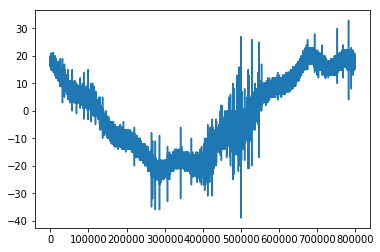

In [8]:
plt.plot(data["0"])

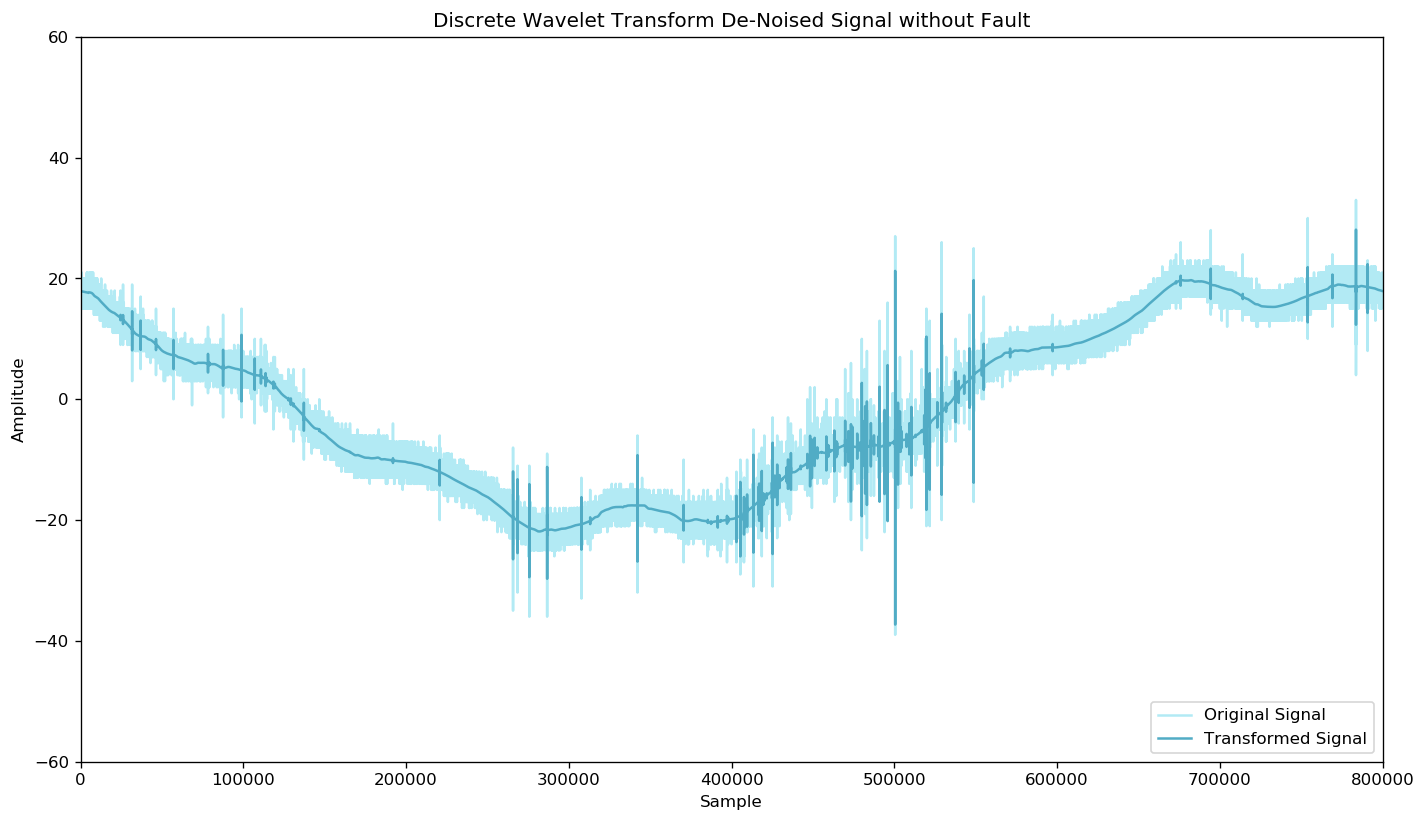

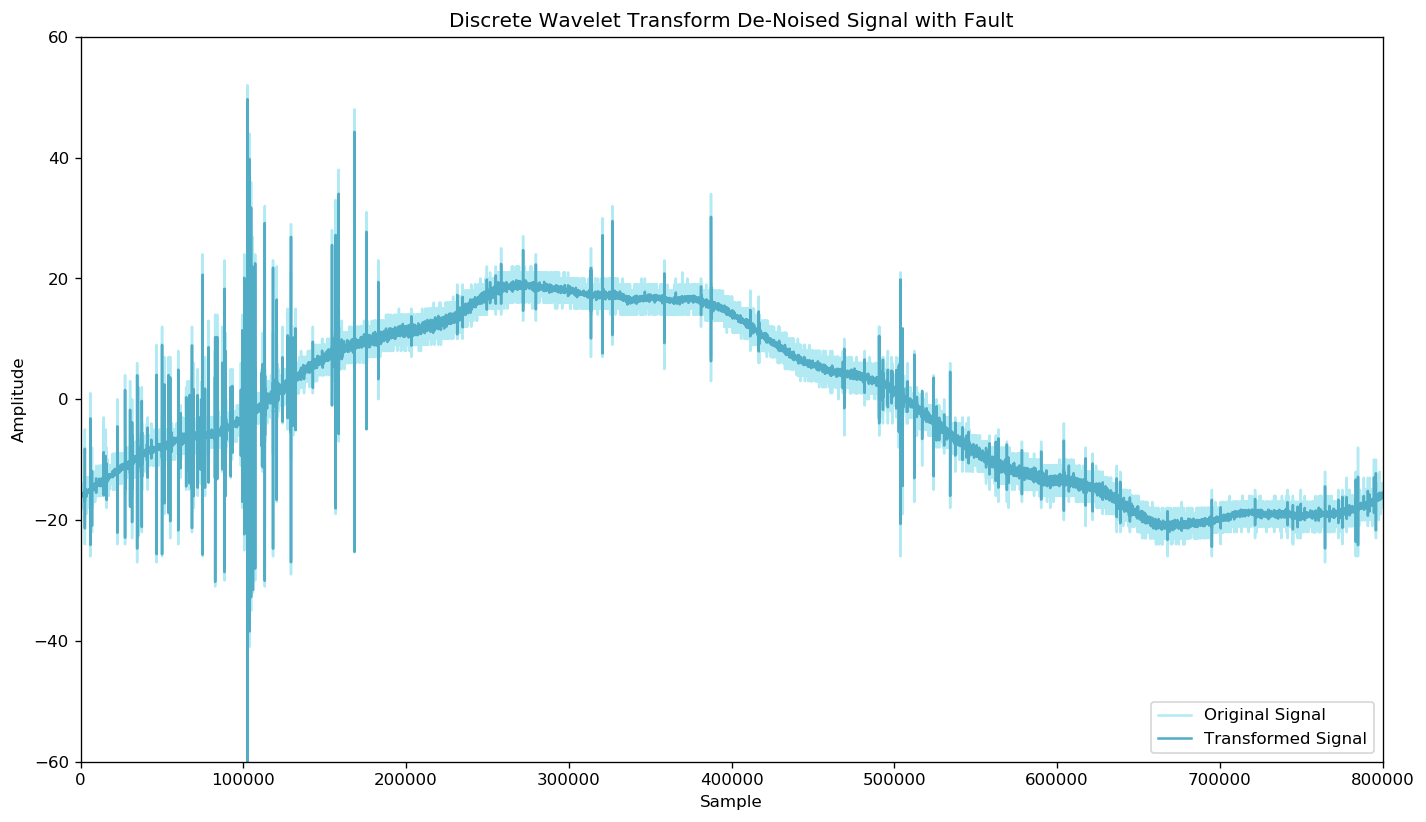

In [4]:
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#51ACC5", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmooth(data["0"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmooth(data["3"], wavelet="db4", level=1, title=title1 )

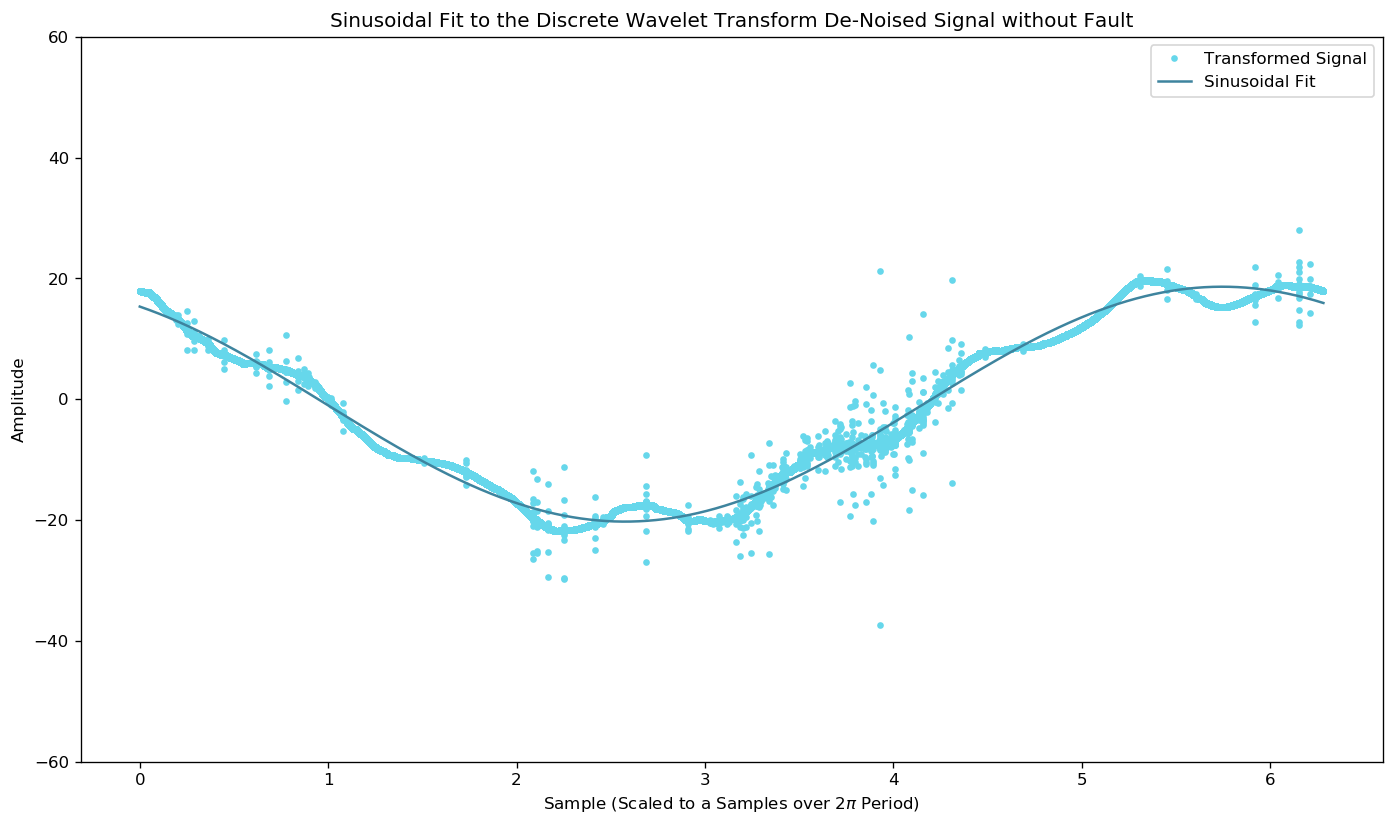

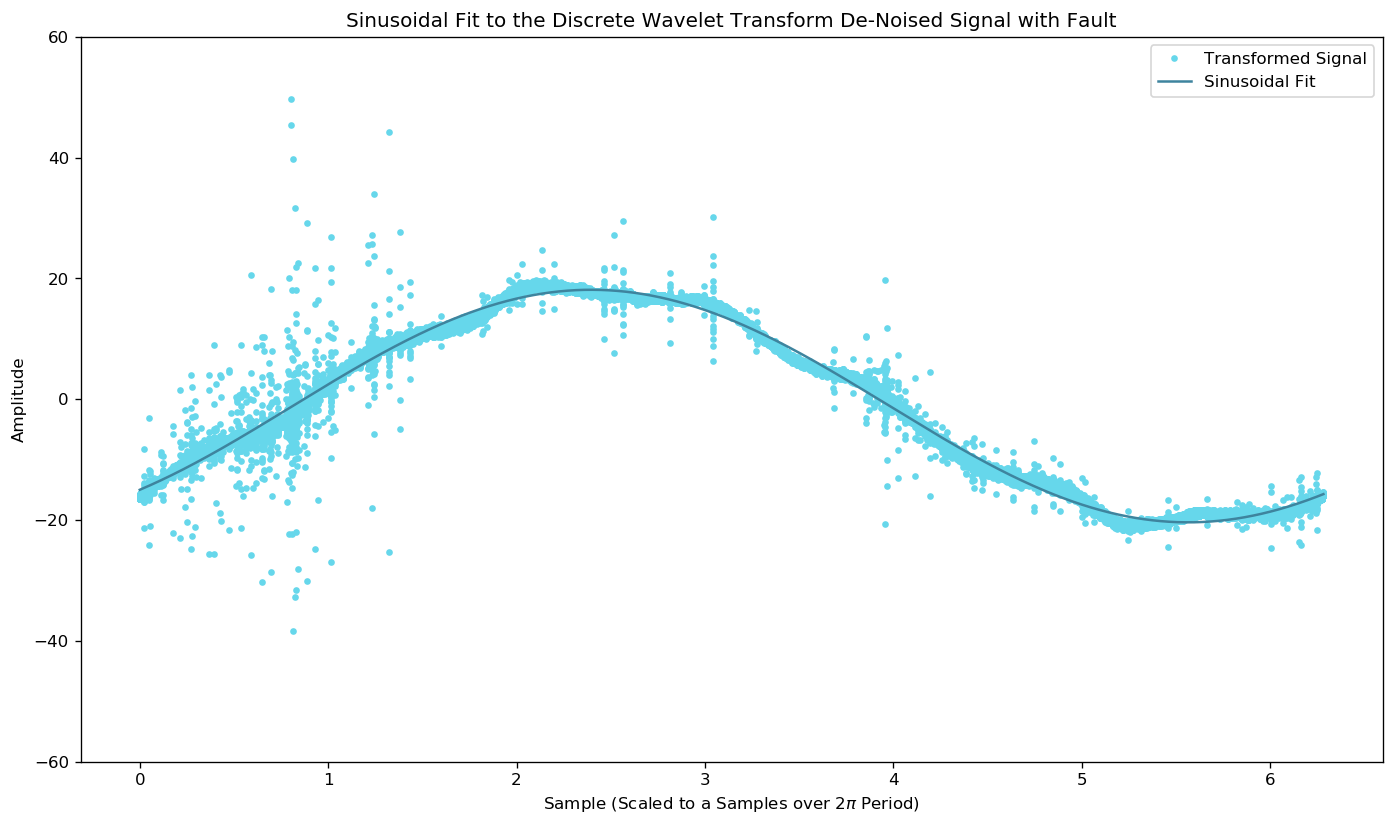

In [5]:
from scipy.optimize import leastsq

#this formula is common on the internet
def fit_sinusoid(signal, title):
    t = np.linspace(0, 2*np.pi, len(signal))  # data covers one period
    guess_mean = np.mean(signal)
    guess_std = 3*np.std(signal)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 20

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - signal
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    signal_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

    # recreate the fitted curve using the optimized parameters
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(t, signal, '.', color=blues[0], label="Transformed Signal")
    plt.plot(t, signal_fit, label="Sinusoidal Fit", color=blues[2])
    plt.xlabel(r"Sample (Scaled to a Samples over 2$\pi$ Period)")
    plt.ylabel("Amplitude")
    plt.ylim((-60, 60))
    plt.title(title)
    plt.legend()
    plt.show()
    return signal_fit

title0 = "Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal without Fault"
title1 = "Sinusoidal Fit to the Discrete Wavelet Transform De-Noised Signal with Fault"
signal_fit0 = fit_sinusoid(signal_0, title0)
signal_fit1 = fit_sinusoid(signal_1, title1)

In [8]:
#takes the derivative of the sine wave then anywhere its greater than zero is considered a high probability region
def find_pd_probable(signal_fit, condition):
    first_derivative = np.gradient(signal_fit)
    return [i for i, elem in enumerate(first_derivative) if condition(elem)]

high_prob_region0 = find_pd_probable(signal_fit0, lambda e: e>0)
high_prob_region1 = find_pd_probable(signal_fit1, lambda e: e>0)

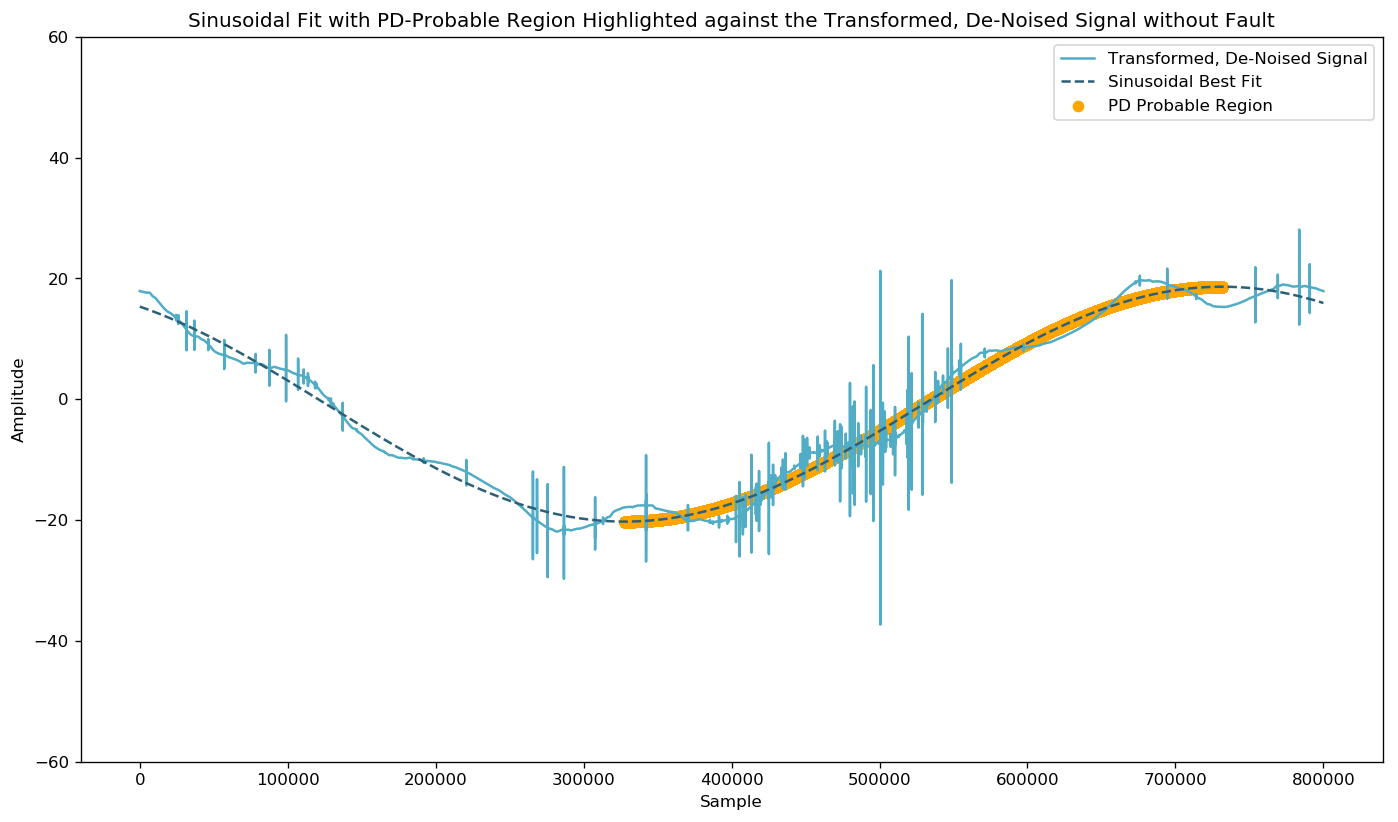

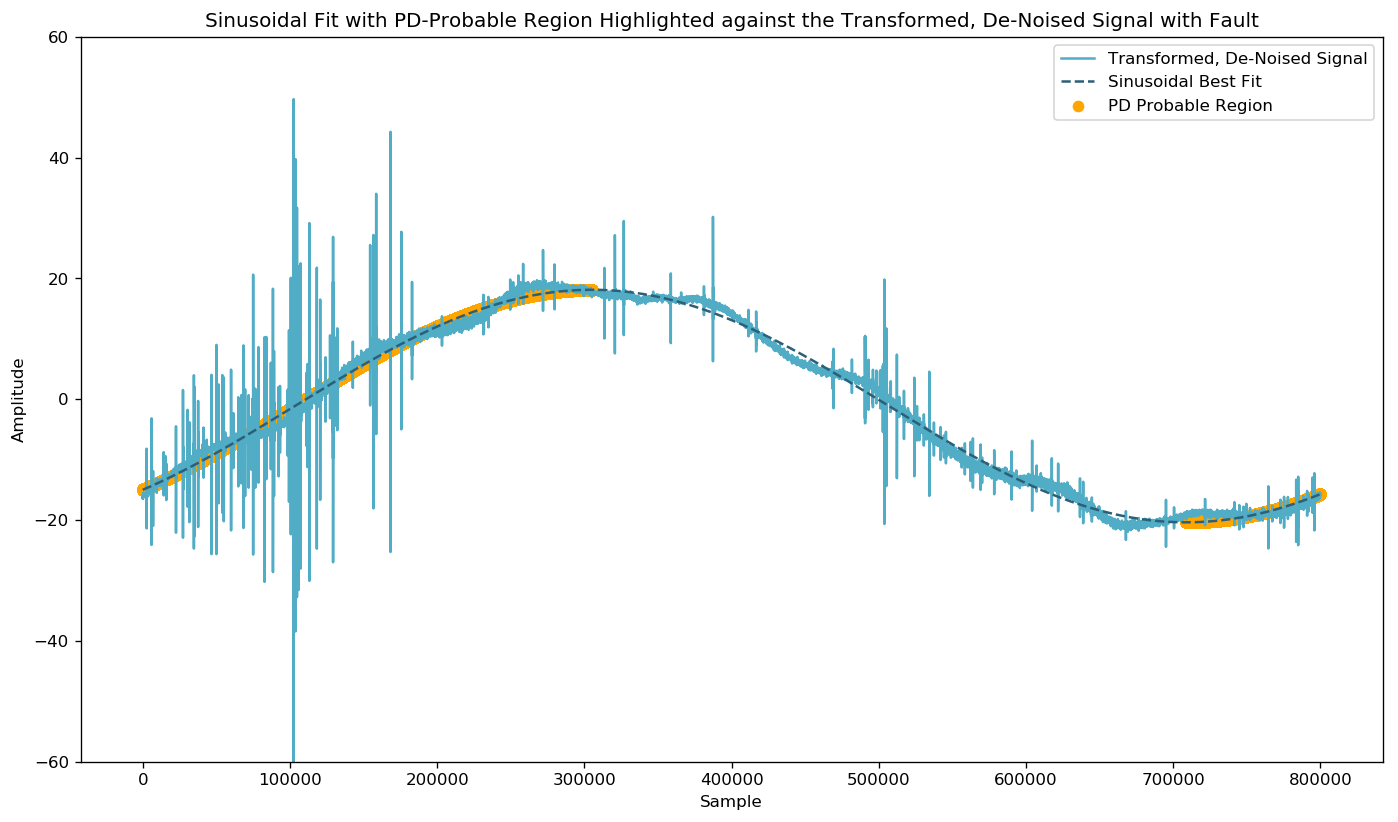

In [9]:
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
def plot_pd_probable(signal, signal_fit, high_prob_region, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(signal, color=blues[1], label="Transformed, De-Noised Signal")
    plt.plot(signal_fit, '--', color=blues[3], label="Sinusoidal Best Fit")
    plt.scatter(high_prob_region, signal_fit[high_prob_region], color="orange", label="PD Probable Region")
    plt.legend()
    plt.ylim((-60, 60))
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")
    plt.title(title)
    return

title0 = "Sinusoidal Fit with PD-Probable Region Highlighted against the Transformed, De-Noised Signal without Fault"
title1 = "Sinusoidal Fit with PD-Probable Region Highlighted against the Transformed, De-Noised Signal with Fault"
plot_pd_probable(signal_0, signal_fit0, high_prob_region0, title0)
plot_pd_probable(signal_1, signal_fit1, high_prob_region1, title1)

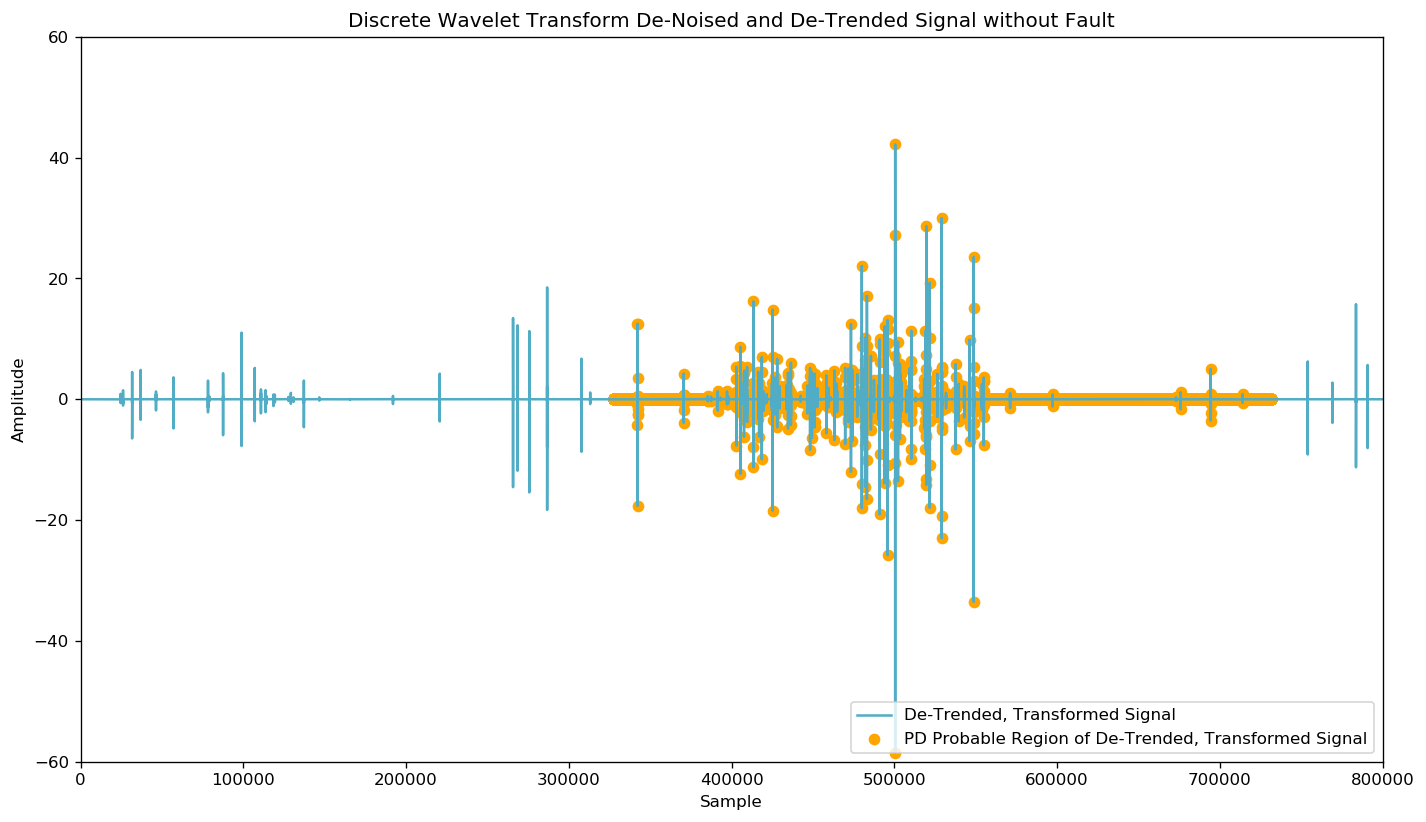

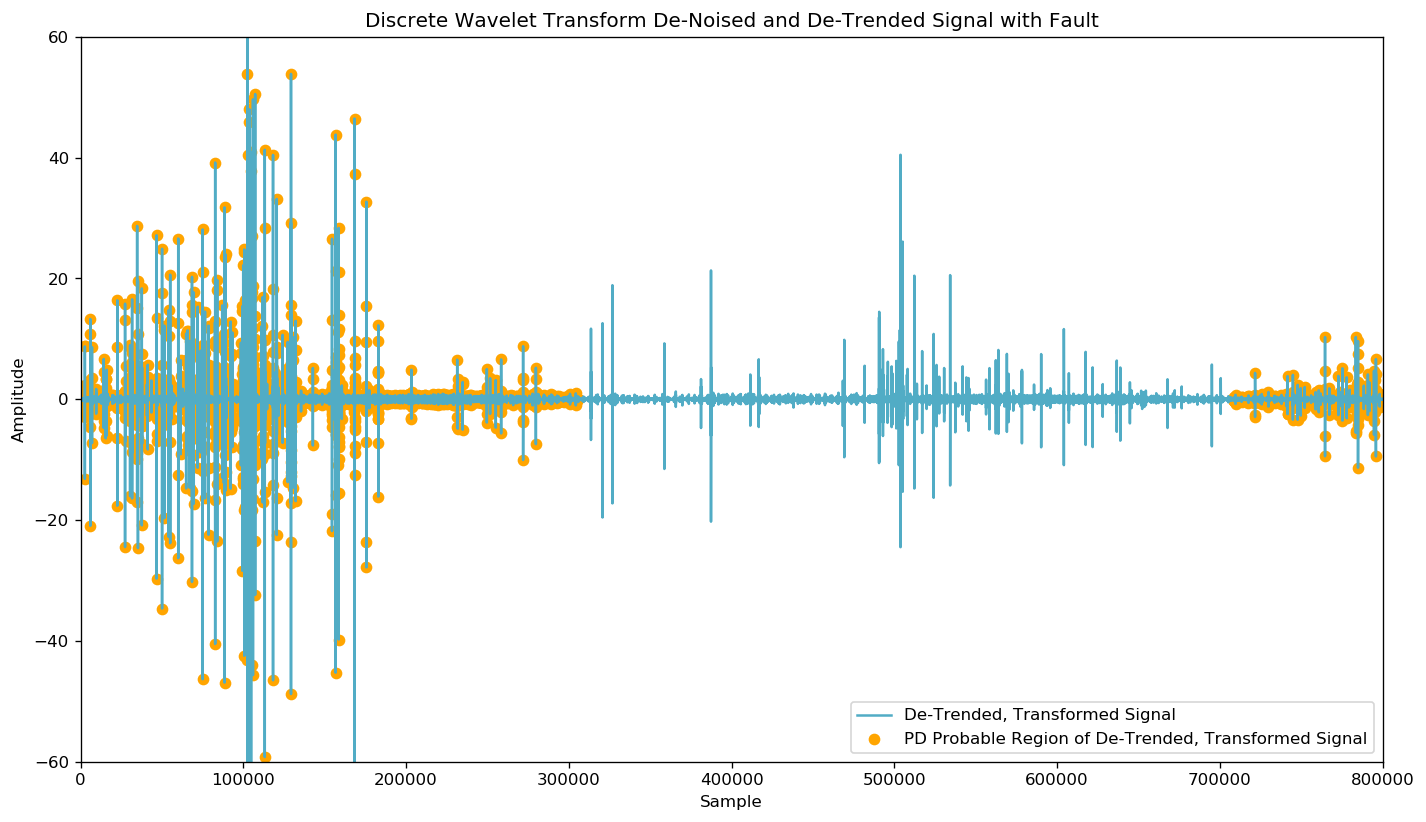

In [10]:
def detrend_signal( signal, high_prob_idx, title=None ):
    #first order difference our signal to zero it out
    x = np.diff(signal, n=1)
    if max(high_prob_idx) == len(x):
        high_prob_idx = high_prob_idx[0:-1]
        
    
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color=blues[1], label="De-Trended, Transformed Signal")
    plt.scatter(high_prob_idx, x[high_prob_idx], color="orange", label="PD Probable Region of De-Trended, Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(x)))
    return x[high_prob_idx]


title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
signal_0hp =  detrend_signal(signal_0, high_prob_region0, title0)
signal_1hp =  detrend_signal(signal_1, high_prob_region1, title1)

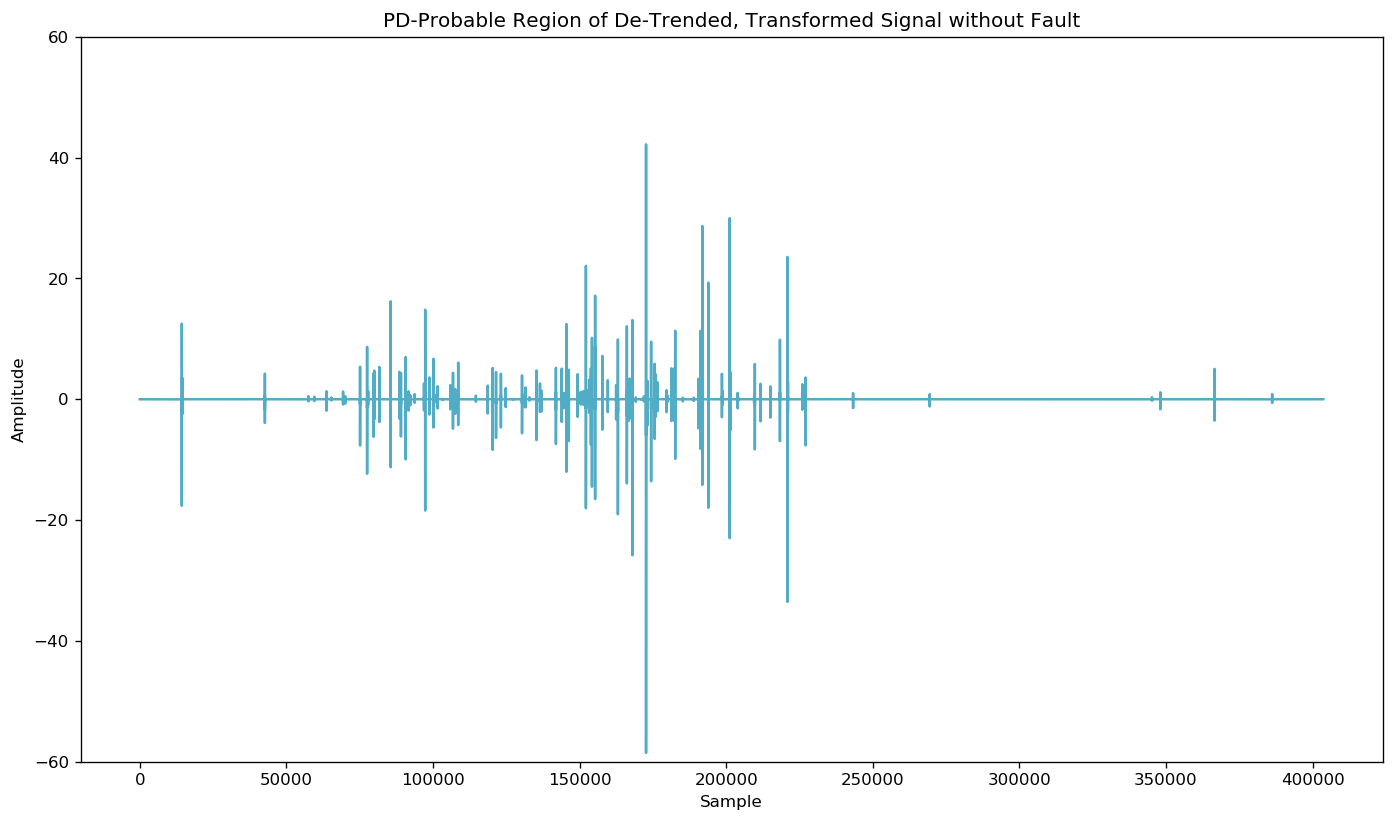

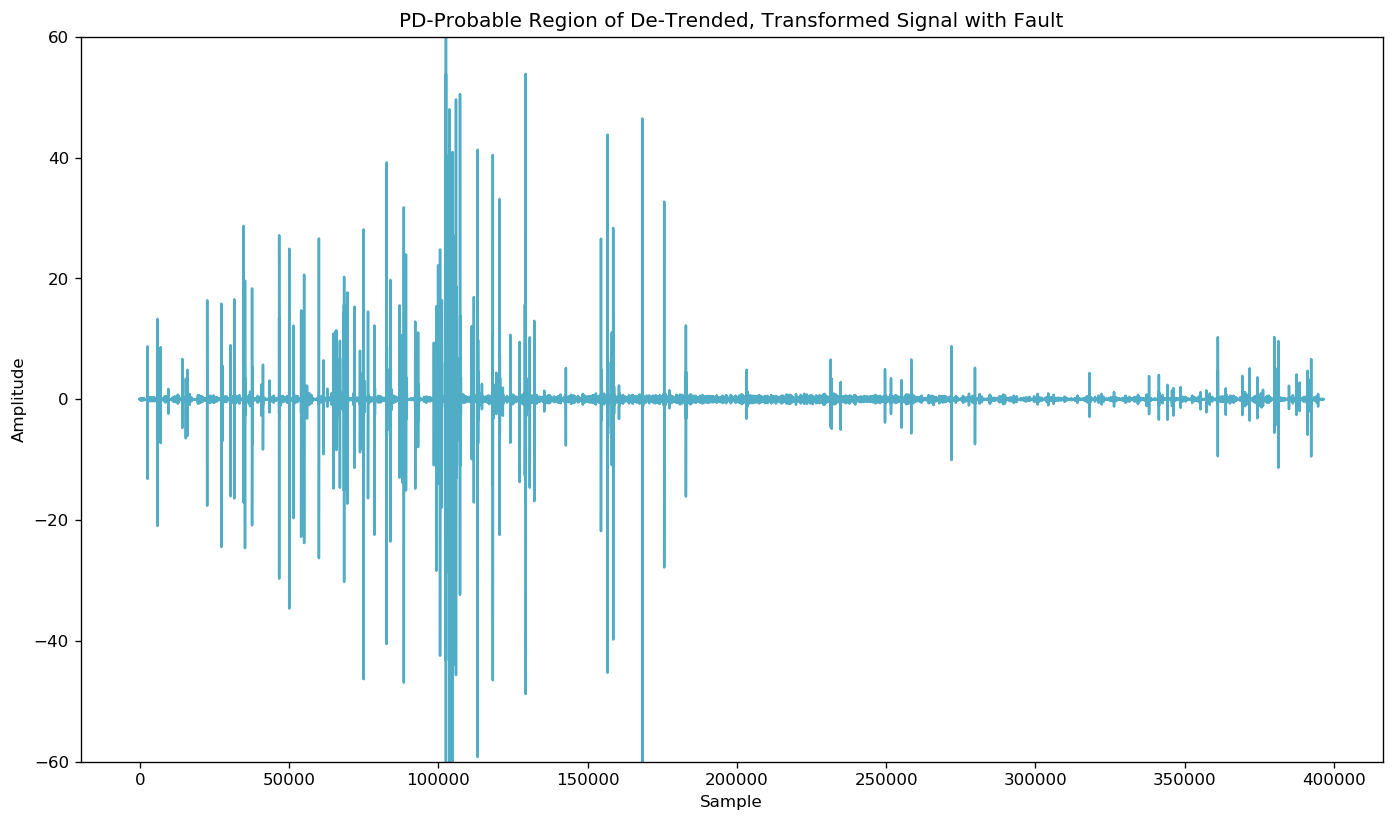

In [11]:
def plot_pd_prob_detrend(signal_hp, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot(signal_hp, color=blues[1])
    plt.ylim((-60, 60))
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.title(title)
    return

title0 = "PD-Probable Region of De-Trended, Transformed Signal without Fault"
title1 = "PD-Probable Region of De-Trended, Transformed Signal with Fault"
plot_pd_prob_detrend(signal_0hp, title0)
plot_pd_prob_detrend(signal_1hp, title1)

139
478


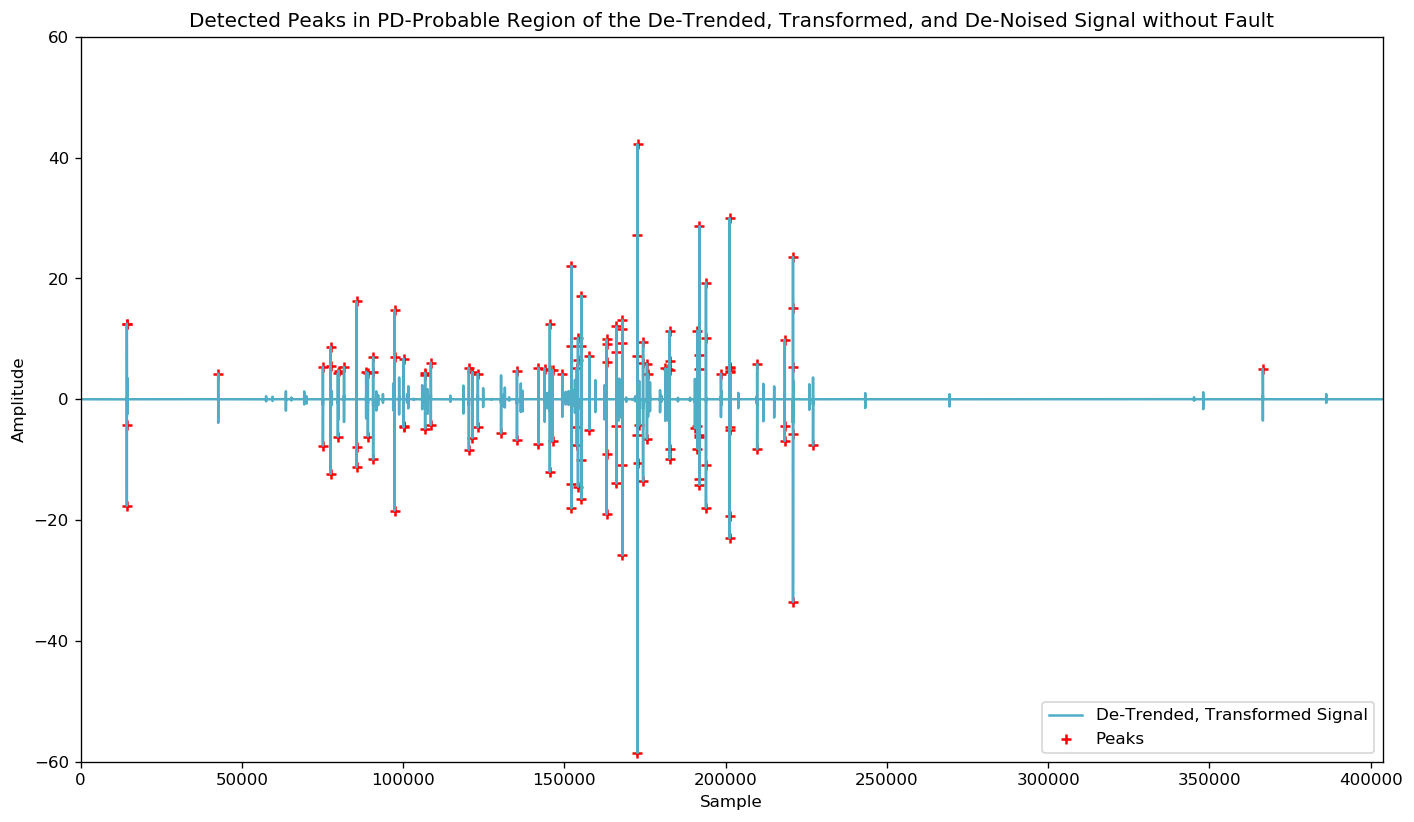

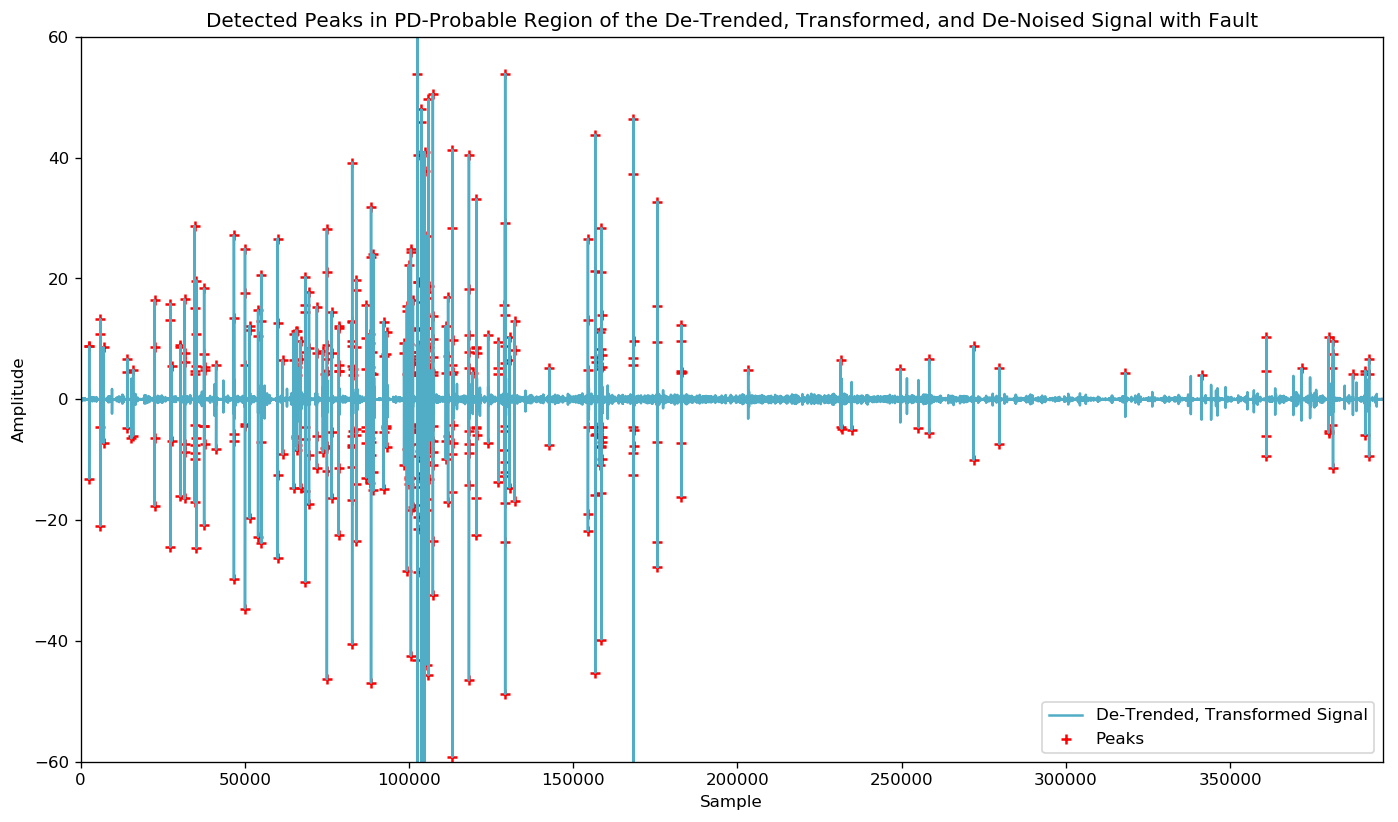

In [12]:
def find_peaks(signal, title):
    thresh = 0.6  # used for peakutils
    thresh = 4.0  # used for fixed amplitude
    min_d = 0

    #peaks = peakutils.indexes(1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    #this is hard coded... we will trust this
    peaks = np.argwhere(signal > thresh)
    #valleys = peakutils.indexes(-1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    valleys = np.array(np.argwhere(signal < -thresh))
    pois = np.sort(np.concatenate((peaks, valleys)))
    
    peak_indexes = []
    for pk in pois:
        #peak_indexes.append(pk)
        peak_indexes.append(pk[0])

    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    #plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    plt.plot( signal, color="#51ACC5", label="De-Trended, Transformed Signal" )
    plt.scatter(peak_indexes, signal[peak_indexes], marker="+", color="red", label="Peaks" )
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((102500, 102600))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    print(len(peak_indexes))
    return np.sort(peak_indexes)

title0 = 'Detected Peaks in PD-Probable Region of the De-Trended, Transformed, and De-Noised Signal without Fault'
title1 = 'Detected Peaks in PD-Probable Region of the De-Trended, Transformed, and De-Noised Signal with Fault'
peak_indexes0 = find_peaks(signal_0hp, title=title0 )
peak_indexes1 = find_peaks(signal_1hp, title=title1 )

In [13]:
def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 20  # 
    max_height_ratio = 0.75  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])

            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

false_peak_indexes0 = cancel_false_peaks(signal_0hp, peak_indexes0)
false_peak_indexes1 = cancel_false_peaks(signal_1hp, peak_indexes1)

In [14]:
#cancels peaks for being too high... most likely so don't get fooled by outliers. PD is not characterized by just 1 large jolt
def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    thresh = 30.0
    #peaks = peakutils.indexes(1.0*(signal), thres=0.80, min_dist=0)
    peaks = np.argwhere(signal > thresh)
    #valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0) 
    valleys = np.argwhere(signal < -thresh)
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx in false_peak_indexes:
            false_peak_indexes.append(pk_idx[0])
    return np.sort(false_peak_indexes)

false_peak_indexes0 = cancel_high_amp_peaks(signal_0hp, peak_indexes0, false_peak_indexes0)
false_peak_indexes1 = cancel_high_amp_peaks(signal_1hp, peak_indexes1, false_peak_indexes1)

In [15]:
# Cancel Peaks Flagged as False, Find True Preaks
def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = set(peak_indexes) - set(false_peak_indexes)
    return np.sort(list(true_peak_indexes))

true_peak_indexes0 = cancel_flagged_peaks(peak_indexes0, false_peak_indexes0)
true_peak_indexes1 = cancel_flagged_peaks(peak_indexes1, false_peak_indexes1)

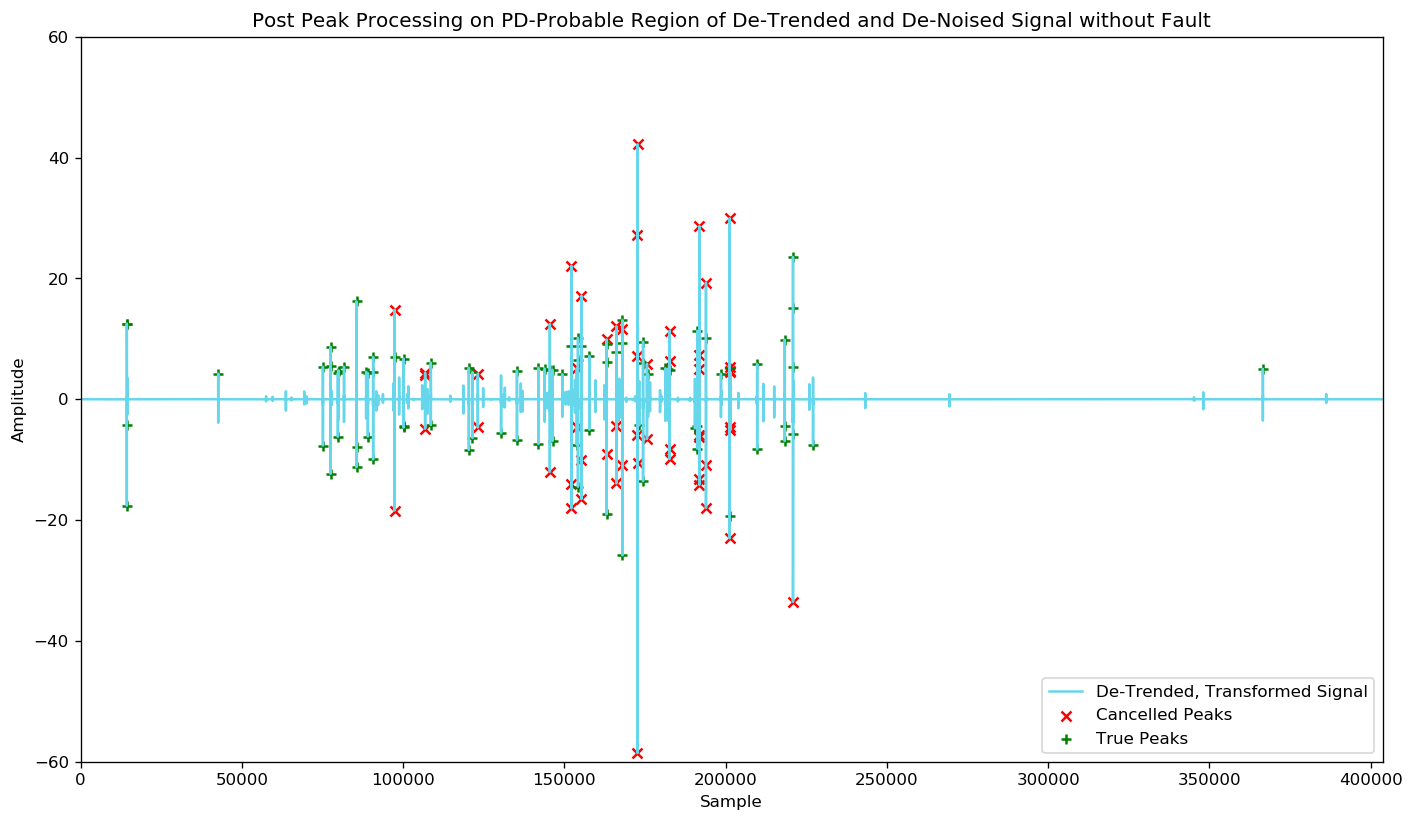

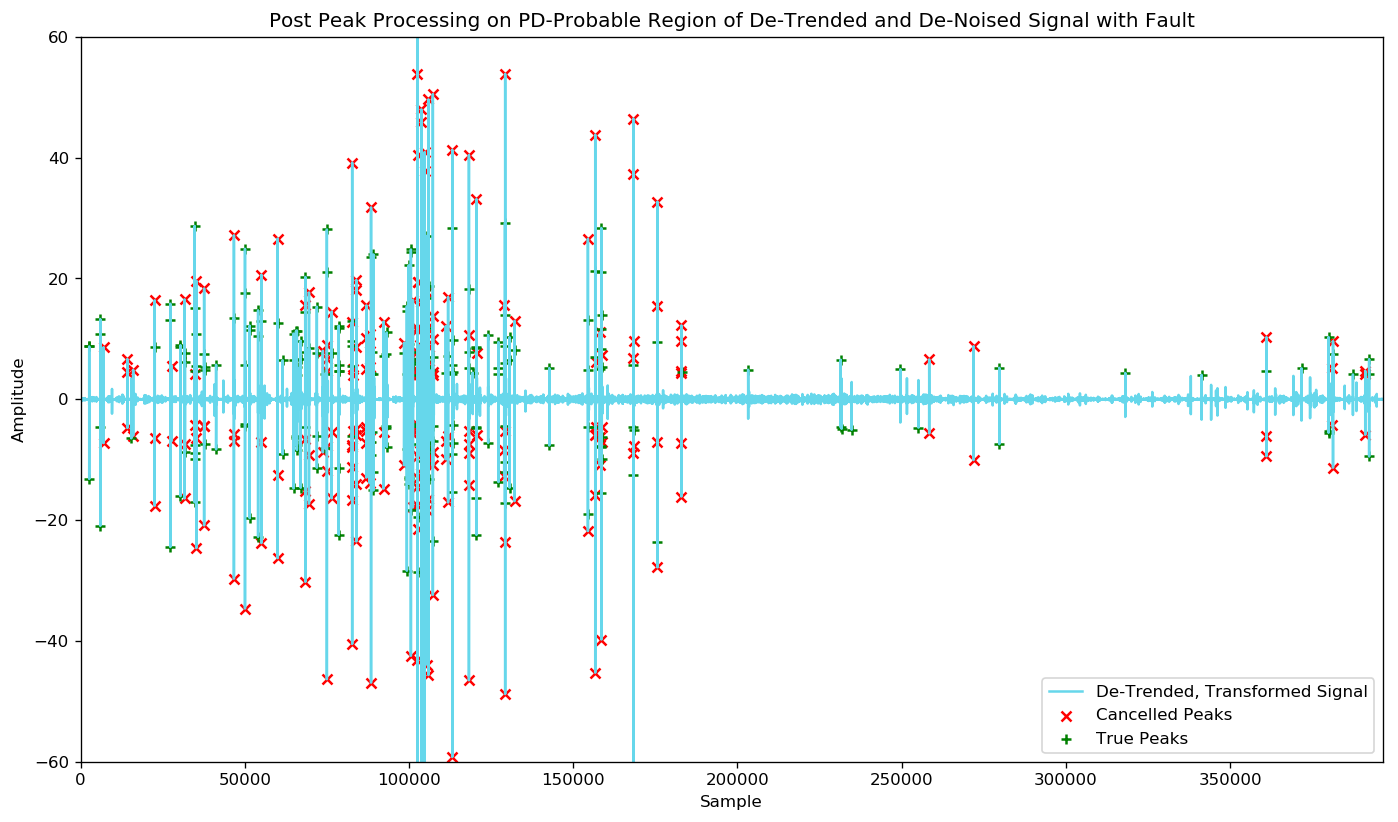

In [16]:
def plot_peaks(signal, true_peak_indexes, false_peak_indexes, title):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot( signal, color="#66D7EB", label="De-Trended, Transformed Signal" )  #5 alt color 1ACC5
    plt.scatter(false_peak_indexes, signal[false_peak_indexes], marker="x", color="red", label="Cancelled Peaks")
    plt.scatter(true_peak_indexes, signal[true_peak_indexes], marker="+", color="green", label="True Peaks")
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((102500, 102600))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    plt.show()
    return

title0 = 'Post Peak Processing on PD-Probable Region of De-Trended and De-Noised Signal without Fault'
title1 = 'Post Peak Processing on PD-Probable Region of De-Trended and De-Noised Signal with Fault'
plot_peaks(signal_0hp, true_peak_indexes0, false_peak_indexes0, title0)
plot_peaks(signal_1hp, true_peak_indexes1, false_peak_indexes1, title1)

Let's try to make his 4 good variables

In [12]:
def find_all_peaks(signal, threshold=0.7, min_distance=0):
    #classify a peak as anything greater than our threshold
    peaks = np.argwhere(signal > 1.0*threshold)
    #valleys are opposites of peaks
    valleys = np.array(np.argwhere(signal < -1.0*threshold))
    pois = np.sort(np.concatenate((peaks, valleys)))
    peak_indexes = []
    for pk in pois:
        #peak_indexes.append(pk)
        peak_indexes.append(pk[0])
    return np.sort(peak_indexes), peaks, valleys


def calculate_peak_widths(peak_idxs):
    tmp_w = 1
    widths = []
    for idx in range(1,len(peak_idxs)):
        if peak_idxs[idx]-peak_idxs[idx-1] < 3:
            tmp_w +=1
        else:
            widths.append(tmp_w)
            tmp_w = 1
    widths.append(tmp_w)
    min_width = min(np.array(widths))
    max_width = max(np.array(widths))
    mean_width = np.nanmean(np.array(widths))
    num_true_peaks = len(widths)
    return min_width, max_width, mean_width, num_true_peaks

def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 500  # 
    max_height_ratio = 0.25  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:  # opposite polarity and within symmetric check distance
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:  # ratio of opposing polarity check
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)  # build pulse train
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    threshold = 50
    #cancel any high amp peaks as these are outliers most likely
    peaks = np.argwhere(signal > 1.0*threshold)
    #valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0)
    valleys = np.argwhere(signal < -1.0*threshold)
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx[0] in false_peak_indexes:
            false_peak_indexes.append(pk_idx[0])
    return false_peak_indexes

def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = list(set(peak_indexes) - set(false_peak_indexes))
    true_peak_indexes.sort()
    return true_peak_indexes

def low_high_peaks(signal, true_peak_indexes, hi_idx, lo_idx):
    if np.size(np.array(hi_idx))> 0:
        lhr = 1.0*np.size(np.array(lo_idx))/np.size(np.array(hi_idx))
    else:
        lhr = 0.0
    hi_true = 0
    lo_true = 0
    for x in true_peak_indexes:
        if signal[x] > 0.0:
            hi_true += 1
        else:
            lo_true += 1
    if hi_true > 0:
        lhrt = 1.0*lo_true/hi_true
    else:
        lhrt = 0.0
    return [hi_true, lo_true]

def calculate_peaks(signal, true_peak_indexes):  # Peak Characteristics on True Peaks
    peak_values = signal[true_peak_indexes]
    num_detect_peak = len(true_peak_indexes)
    if num_detect_peak > 0:
        min_height = min(peak_values)
        max_height = max(peak_values)
        mean_height = np.nanmean(peak_values)
        min_width, max_width, mean_width, num_true_peaks = calculate_peak_widths(true_peak_indexes)
        return [num_detect_peak, num_true_peaks]
    else:
        return [0, 0]

In [13]:
def waveletSmooth( x, wavelet="db4", level=1):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y


#this formula is common on the internet
def fit_sinusoid(signal):
    t = np.linspace(0, 2*np.pi, len(signal))  # data covers one period
    guess_mean = np.mean(signal)
    guess_std = 3*np.std(signal)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 20

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - signal
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    signal_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
    return signal_fit


#takes the derivative of the sine wave then anywhere its greater than zero is considered a high probability region
def find_pd_probable(signal_fit, condition):
    first_derivative = np.gradient(signal_fit)
    return [i for i, elem in enumerate(first_derivative) if condition(elem)]


def detrend_signal( signal, high_prob_idx):
    #first order difference our signal to zero it out
    x = np.diff(signal, n=1)
    if len(high_prob_idx) > 0:
        if max(high_prob_idx) == len(x):
            high_prob_idx = high_prob_idx[0:-1]
        
    
    return x[high_prob_idx]

#feed this into get_features function
def get_features(signal, signal_id, threshold, min_distance): # Extract features from the signal and build an array of them
    
    peak_indexes, hi_idx, lo_idx = find_all_peaks(signal, threshold, min_distance)
    
    false_peak_indexes = cancel_false_peaks(signal, peak_indexes)
    
    false_peak_indexes = cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes)
    
    true_peak_indexes = cancel_flagged_peaks(peak_indexes, false_peak_indexes)

    peaks = calculate_peaks(signal, true_peak_indexes)
    low_high_stats = low_high_peaks(signal, true_peak_indexes, hi_idx, lo_idx)
    return peaks + low_high_stats

In [15]:
from scipy.optimize import leastsq
threshold = 0.45  # Threshold for db_bit fixed threshold, not peak_detector package
min_distance = 0  # Minimum distance in samples between detected peaks


signal_id = 0  # in this example use signal_id = 0
signal_0 =  waveletSmooth(data["0"], wavelet="db4", level=1)
signal_fit0 = fit_sinusoid(signal_0)
high_prob_region0 = find_pd_probable(signal_fit0, lambda e: e>0)
signal_0hp =  detrend_signal(signal_0, high_prob_region0)
signal_features = get_features(signal_0hp, signal_id, threshold, min_distance)

#this returns the total number of true peaks, # of hi peaks, # of low peaks and number of peaks in general
#these were the top 4 variables he found

In [17]:
signal_features

[27, 25, 13, 14]

In [ ]:
my_data = []
total_size = len(df_train)
for start, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
    praq_train = pq.read_pandas('train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    for i in tqdm(range(start,end)):
        signal_0 =  waveletSmooth(praq_train[str(i)], wavelet="db4", level=1)
        signal_fit0 = fit_sinusoid(signal_0)
        high_prob_region0 = find_pd_probable(signal_fit0, lambda e: e>0)
        signal_0hp =  detrend_signal(signal_0, high_prob_region0)
        signal_features = get_features(signal_0hp, signal_id, threshold, min_distance)
        my_data.append(signal_features)
np.save("X_waves.npy",my_data)